INFO:clients.binance_client:Cliente inicializado en modo público (solo lectura)
INFO:clients.binance_client:Obtenidos 500 datos para BNBUSDT (1m)
INFO:analysis.indicators:Calculando indicadores para BNBUSDT (500 velas)
INFO:analysis.indicators:Resistencias detectadas: 7
INFO:analysis.indicators:Soportes detectados: 6
INFO:analysis.indicators:Tendencia: BAJISTA
INFO:analysis.indicators:Volatilidad: 0.07%
INFO:analysis.indicators:Cambio total: -1.59%
INFO:visualization.chart_plotter:Generando gráfico para BNBUSDT



ANÁLISIS DE BTCUSDT
Precio actual: $892.22
Tendencia: BAJISTA
Volatilidad: 0.07%
Cambio: -1.59%

Resistencias: 7 detectadas
Soportes: 6 detectados

Para LONG:
  Stop Loss: $891.39
  Take Profit: $893.87


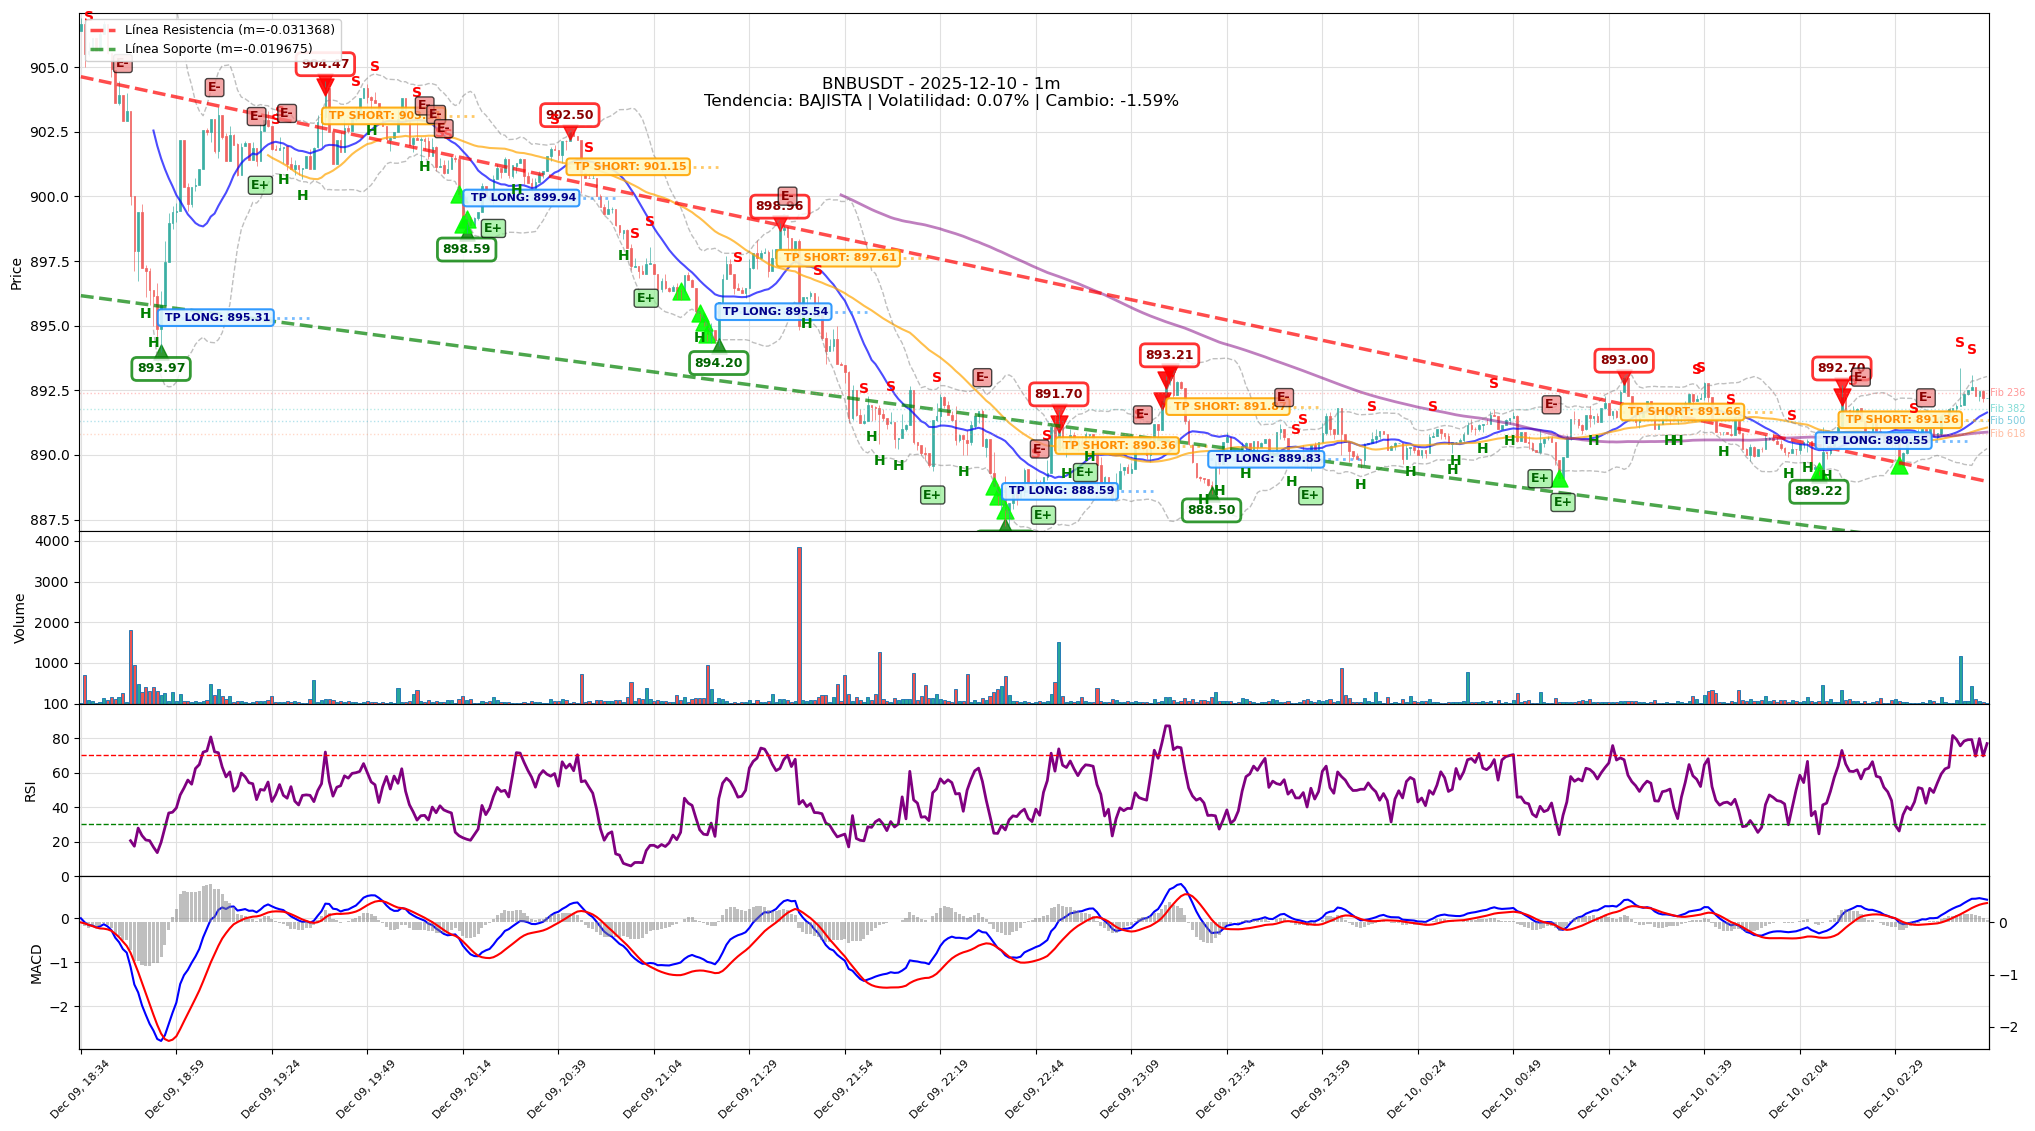

INFO:visualization.chart_plotter:Gráfico generado exitosamente


In [2]:
from clients.binance_client import BinanceClient
from analysis.indicators import calcular_indicadores
from visualization.chart_plotter import graficar_analisis

# Inicializar cliente
binance = BinanceClient()
symbol='ETHUSDT'
# Obtener datos
df = binance.history(symbol, '1m', 500)

# Calcular indicadores
fecha = df.index[-1].strftime('%Y-%m-%d')
comision = binance.calcular_comision(symbol)
datos = calcular_indicadores(symbol, fecha, '1m', df, comision)

# Ver resultados
print(f"\n{'='*50}")
print(f"ANÁLISIS DE BTCUSDT")
print(f"{'='*50}")
print(f"Precio actual: ${datos['precio_actual']:.2f}")
print(f"Tendencia: {datos['tendencia']}")
print(f"Volatilidad: {datos['volatilidad']:.2f}%")
print(f"Cambio: {datos['cambio_porcentual']:+.2f}%")
print(f"\nResistencias: {len(datos['resistance_levels'])} detectadas")
print(f"Soportes: {len(datos['support_levels'])} detectados")
print(f"\nPara LONG:")
print(f"  Stop Loss: ${datos['sl_long']:.2f}")
print(f"  Take Profit: ${datos['tp_long']:.2f}")

# Graficar
graficar_analisis(datos, mostrar_avanzado=True)